## Recuperación de Información
# Práctica 3.1 y 3.2 &mdash; Búsqueda Web y Recomendación - PageRank y Relevance Feedback
### Autores: *nombre de los estudiantes aquí*

In [ ]:
#Librerias importadas
import numpy as np

# 1.  Parte 1

## 1.1 Calcular PageRank en el subgrafo web formado por las páginas accesibles desde (e incluyendo) [esta dirección](http://arantxa.ii.uam.es/~abellogin/ir/C.html).

Tomar r = 0.1, N = nº de páginas en el subgrafo, y 0.3 como valor inicial de PageRank para empezar a iterar.

Nota: para grafos con pocos nodos, es también viable resolver la fórmula de PageRank como un sistema de ecuaciones, en lugar de iterar.

### Obtención del grafo

Para poder calcular el PageRank del subgrafo, es necesario tener conocimiento de cómo está organizado con el *número de nodos* y *enlaces*.

In [ ]:
""" Obtención del grafo """
web_base = 'http://arantxa.ii.uam.es/~abellogin/ir/%s.html'

# Diccionario de direcciones {página-enlaces}
graf = {}

# Lista de nodos pendientes:
""" Obtención del grafo """
pendientes = ['C']
import requests
from bs4 import BeautifulSoup

web_base = 'http://arantxa.ii.uam.es/~abellogin/ir/%s.html'

# Diccionario de direcciones {página-enlaces}
graf = {}

# Lista de nodos pendientes:
pendientes = ['C']

# Creamos un bucle que pasee por las páginas
while pendientes:
    # Tomamos la primera página de la lista de pendientes
    web = pendientes.pop(0)
    # Comprobamos si la página está en el diccionario
    if web not in graf:
        # Obtenemos los enlaces
        response = requests.get(web_base % web)
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')
            links = [link.get('href').replace('.html', '').replace('./', '') for link in soup.find_all('a')]

            # Añadimos al diccionario
            graf[web] = links

            # Añadimos a lista de páginas pendientes
            for link in links:
                if link not in graf:
                    pendientes.append(link)

# Imprimir el grafo obtenido
print(graf)


{'C': ['A', 'D', 'E'], 'A': ['B', 'E'], 'D': ['C'], 'E': ['B'], 'B': []}


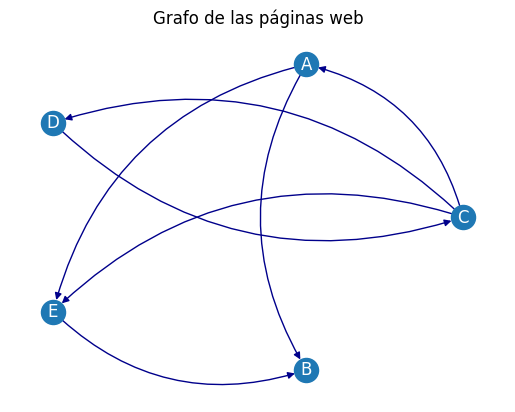

In [ ]:
# Dibujar gráfica
import networkx as nx
import matplotlib.pyplot as plt

# Crear un grafo dirigido
G = nx.DiGraph()

# Agregar nodos al grafo
for pagina, enlaces in graf.items():
    G.add_node(pagina)
    for enlace in enlaces:
        G.add_node(enlace)
        G.add_edge(pagina, enlace)

# Dibujar el grafo
pos = nx.spring_layout(G, seed=42)  # Posiciones de los nodos

# Definir el espacio entre los arcos bidireccionales
edge_labels = nx.get_edge_attributes(G, 'weight')
edge_colors = ['red' if edge in edge_labels else 'darkblue' for edge in G.edges()]

pos = nx.circular_layout(G)  # Posiciones de los nodos
nx.draw_networkx_nodes(G, pos, node_size=300)
nx.get_node_attributes(G, name='pagina')
nx.draw_networkx_labels(G,pos,font_color='white')
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, arrows=True, connectionstyle='arc3,rad=0.3')


plt.title('Grafo de las páginas web')
plt.axis('off')
plt.show()

Ahora que tenemos el grafo de la configuración de las páginas con sus respectivos enlaces, comenzamos con el cálculo PegeRank:

In [ ]:
# Calcular PageRank
def calcular_pagerank(graph, alpha_factor=0.85, epsilon=1.0e-8, max_iterations=100):
    # Inicializar el PageRank de cada página
    pagerank = {node: 1 / len(graph) for node in graph}

    # Iterar hasta la convergencia o el número máximo de iteraciones
    for _ in range(max_iterations):
        # Crear una copia del PageRank actual
        new_pagerank = pagerank.copy()
        # Calcular el PageRank para cada página
        for node in graph:
            # Calcular la suma de PageRank de todas las páginas que apuntan a la página actual
            incoming_pagerank = sum(pagerank[incoming_node] / len(graph[incoming_node]) for incoming_node in graph if node in graph[incoming_node])
            # Calcular el nuevo PageRank para la página actual
            new_pagerank[node] = (1 - alpha_factor) / len(graph) + alpha_factor * incoming_pagerank
        # Verificar la convergencia
        if sum(abs(new_pagerank[node] - pagerank[node]) for node in graph) < epsilon:
            break
        # Actualizar el PageRank
        pagerank = new_pagerank

    return pagerank

# Grafo de ejemplo
graph = {'C': ['A', 'D', 'E'], 'A': ['B', 'E'], 'D': ['C'], 'E': ['B'], 'B': []}

# Calcular el PageRank del grafo
pagerank = calcular_pagerank(graf)
print("PageRank:", pagerank)


PageRank: {'C': 0.07310647756303099, 'A': 0.05071350301533058, 'D': 0.05071350301533058, 'E': 0.07226674179684608, 'B': 0.11297997086754236}


In [ ]:
def calcular_matriz_S(graph):
    # Crear un diccionario para mapear los nodos a índices numéricos
    node_index = {node: i for i, node in enumerate(graph)}
    n = len(graph)
    S = np.zeros((n, n))

    for i, node in enumerate(graph):
        if not graph[node]:  # Si el nodo no tiene enlaces salientes
            S[:, i] = 1 / n  # Nodo de teletransportación
        else:
            for target_node in graph[node]:
                j = node_index[target_node]
                S[j, i] = 1 / len(graph[node])  # Enlace de i a j

    return S

In [ ]:
# calcular_matriz_teleportacion_uniforme
def calcular_matriz_E(graph):
    n = len(graph)
    e = np.ones((n, 1)) / n
    E = (1 / n) * np.dot(e, e.T)
    return E

In [ ]:
matriz_S = calcular_matriz_S(graf)
matriz_E = calcular_matriz_E(graf)
r = 0.85

matriz_G = r * matriz_S + ( (1-r) * matriz_E)
print(np.round(matriz_G,4))

[[0.0012 0.0012 0.8512 0.0012 0.1712]
 [0.2845 0.0012 0.0012 0.0012 0.1712]
 [0.2845 0.0012 0.0012 0.0012 0.1712]
 [0.2845 0.4262 0.0012 0.0012 0.1712]
 [0.0012 0.4262 0.0012 0.8512 0.1712]]


## 1.2 Cálculo de PageRank personalizado

Con los mismos parámetros del apartado anterior, personalizar PageRank para un usuario que tiene sólo las páginas 'A.html' y 'D.html' entre sus preferencias.

In [ ]:
def calcular_pagerank_personalizado(graph, preferencias, damping_factor=0.85, epsilon=1.0e-8, max_iterations=100):
    # Inicializar el PageRank de cada página
    pagerank = {node: 0 for node in graph}  # Inicializar a 0

    # Ajustar el PageRank para las páginas de preferencia
    total_preferencias = len(preferencias)
    for node in preferencias:
        pagerank[node] = 1 / total_preferencias

    # Iterar hasta la convergencia o el número máximo de iteraciones
    for _ in range(max_iterations):
        # Crear una copia del PageRank actual
        new_pagerank = pagerank.copy()
        # Calcular el PageRank para cada página
        for node in graph:
            # Calcular la suma de PageRank de todas las páginas que apuntan a la página actual
            incoming_pagerank = sum(pagerank[incoming_node] / len(graph[incoming_node]) for incoming_node in graph if node in graph[incoming_node])
            # Calcular el nuevo PageRank para la página actual
            new_pagerank[node] = (1 - damping_factor) / len(graph) + damping_factor * incoming_pagerank
        # Verificar la convergencia
        if sum(abs(new_pagerank[node] - pagerank[node]) for node in graph) < epsilon:
            break
        # Actualizar el PageRank
        pagerank = new_pagerank

    return pagerank

# Grafo de ejemplo
graph = {'C.html': ['A.html', 'D.html', 'E.html'], 'A.html': ['B.html', 'E.html'], 'D.html': ['C.html'], 'E.html': ['B.html'], 'B.html': []}

# Preferencias del usuario
preferencias_usuario = ['A.html', 'D.html']

# Calcular el PageRank personalizado para el usuario
pagerank_personalizado = calcular_pagerank_personalizado(graf, preferencias_usuario)
print("PageRank personalizado para el usuario:", pagerank_personalizado)

PageRank personalizado para el usuario: {'C': 0.07310647361629302, 'A': 0.05071349971580687, 'D': 0.05071349971580687, 'E': 0.07226673652395338, 'B': 0.1129799599981498, 'A.html': 0.5, 'D.html': 0.5}


## Opcional 1.A

Probar valores distintos de r para calcular PageRank.

In [ ]:
# TODO

# 2.  Parte 2

## 2.1 Cálculo de relevance feedback

Sobre alguna consulta que hayas usado en prácticas anteriores (para la que tengas calculada los valores de TF-IDF), aplicar relevance feedback (una iteración) según las siguientes opciones.

1. Sistema/ránking de partida
    1. Google (obtenido en el proceso de recogida de datos).
    2. Modelo vectorial (VSM obtenido en la práctica 1 ej. 1).
    3. PRP modelo BIR ó document likelihood modelo 1 ó 2.
2. Técnica RF a usar:
    1. Para Google y VSM, expansión de consulta por el método Rocchio.
    2. Para los modelos probabilísticos, uso del conjunto de documentos feedback en la reestimación de probabilidades, según corresponde a cada método.
3. Fuente de feedback:
    * i) Clicks como feedback de relevancia implícita positiva usando el log de clicks de la práctica 2.
    * ii) Pseudo-relevance feedback (PRF): los documentos top n devueltos por el propio sistema. Nota: esta es la opción natural de BIR y document likelihood, pero tienen igualmente sentido el uso de clicks o juicios de relevancia (como prueba de concepto).
    * iii) Oráculo: juicios de relevancia (de la práctica 2) como feedback explícito de relevancia positiva y negativa. Nota: esta opción no corresponde a un escenario real (donde el feedback lo daría un usuario final en lugar de un asesor) ni a una evaluación “justa” en laboratorio (pues le enseñamos al sistema las “soluciones” a la pregunta sobre la que va a ser evaluado), pero sirve como prueba de contraste con las otras opciones.

Quedan a criterio del estudiante:
 - Los parámetros alfa, beta y gamma en Rocchio.
 - La profundidad del cutoff top-n en PRF.
 - El número de términos en la expansión de consultas y el criterio para seleccionarlos.

Observación: en el apartado 1.1, la interfaz de Google no contempla la ponderación de términos de consulta, de modo que se añadirán a la consulta términos sin peso. Cabría considerar pesos enteros (p.e. multiplicando los pesos por una constante y redondeándolos), que se pueden plasmar como términos repetidos en la consulta. El estudiante puede experimentar si lo desea con esta idea.

In [ ]:
# Aplicación Relevance Feedback con las consultas de la práctica 1

# Obtención de la tabla de pesos tf-idf de la P1

# Obtener los clicks de cada enlace

# Establecer los valores alpha, beta, gamma

# Obtener los valores q_m



## 2.2 Comparar efectividad

Comparar la efectividad de los ránkings resultantes de aplicar relevance feedback en comparación con el ránking inicial, en términos de precisión y nDCG.

Nota: para Google (apartado 2.1), el propio estudiante tendrá que añadir juicios de relevancia a los nuevos documentos que pueda devolver Google para la consulta expandida.

In [ ]:
# TODO

## 2.3 Informe

Escribir un informe con los resultados y detalles de los métodos y fórmulas aplicados, así como las diferencias observadas entre los resultados de las diferentes opciones y modelos.

(por hacer)

## Opcional 2.A

Probar a realizar varias iteraciones de relevance feedback en aquellos métodos donde sea viable y/o tenga más sentido (p.e. es más difícil con buscadores comerciales, ya que entrarían nuevos documentos de los que habría que extraer el vector de palabras, y -salvo para PRF- obtener nuevos clicks y/o juicios de relevancia).

In [ ]:
# TODO

## Opcional 2.B

Probar valores diferentes de alfa, beta y gamma en Rocchio, diferentes cutoff en PRF, y/o diferente nº de términos de expansión.

In [ ]:
# TODO

## Opcional 2.C

Probar con diferentes consultas y comparar si los resultados que se obtienen son consistentes con los obtenidos usando la consulta de los primeros apartados.

In [ ]:
# TODO